In [81]:
import os
import json
import shapefile
import numpy as np
import pandas as pd
import pyproj

from pathlib import Path
import easyidp as idp

In [2]:
def nms(arr, thresh):
    # reference: https://zhuanlan.zhihu.com/p/128125301
    
    # 首先数据赋值和计算对应矩形框的面积
    # arr的数据格式是arr = [[ xmin, ymin, xmax, ymax,scores]....]

    x1 = arr[:, 0]
    y1 = arr[:, 1]
    x2 = arr[:, 2]
    y2 = arr[:, 3]
    score = arr[:, 4]

    # 所有矩形框的面积
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)

    # 取出分数从大到小排列的索引。.argsort()是从小到大排列，[::-1]是列表头和尾颠倒一下。
    order = score.argsort()[::-1]
    # 上面这两句比如分数score = [0.72 0.8  0.92 0.72 0.81 0.9 ]
    # 对应的索引order = [2, 5, 4, 1, 3, 0]记住是取出索引，scores列表没变。

    # 这边的keep用于存放，NMS后剩余的方框
    keep = []

    # order会剔除遍历过的方框，和合并过的方框
    while order.size > 0:
        # 取出第一个方框进行和其他方框比对，看有没有可以合并的，就是取最大score的索引
        i = order[0]

        # 因为我们这边分数已经按从大到小排列了。
        # 所以如果有合并存在，也是保留分数最高的这个，也就是我们现在那个这个
        # keep保留的是索引值，不是具体的分数。
        keep.append(i)

        # 计算交集的左上角和右下角
        # 这里要注意，比如x1[i]这个方框的左上角x和所有其他的方框的左上角x的
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        # 这边要注意，如果两个方框相交，xx2-xx1和yy2-yy1是正的。
        # 如果两个方框不相交，xx2-xx1和yy2-yy1是负的，我们把不相交的w和h设为0.
        w = np.maximum(0, xx2-xx1+1)
        h = np.maximum(0, yy2-yy1+1)
        # 计算重叠面积就是上面说的交集面积。不相交因为W和H都是0，所以不相交面积为0
        inter = w * h

        # 这个就是IOU公式（交并比）。
        # 得出来的ious是一个列表，里面拥有当前方框和其他所有方框的IOU结果。
        ious = inter / (areas[i] + areas[order[1:]] - inter)

        # 接下来是合并重叠度最大的方框，也就是合并ious中值大于thresh的方框
        # 我们合并的操作就是把他们剔除，因为我们合并这些方框只保留下分数最高的。
        # 我们经过排序当前我们操作的方框就是分数最高的，所以我们剔除其他和当前重叠度最高的方框
        # 这里np.where(ious<=thresh)[0]是一个固定写法。
        index = np.where(ious <= thresh)[0]

        # 把留下来框在进行NMS操作
        # 这边留下的框是去除当前操作的框，和当前操作的框重叠度大于thresh的框
        # 每一次都会先去除当前操作框（n个框计算n-1个IOU值），所以索引的列表就会向前移动移位，要还原就+1，向后移动一位
        order = order[index+1]

    return keep

In [3]:
NAS_ROOT = Path("/home/crest/w/hwang_Pro/data/202509_tanashi_broccoli")

dom_path = NAS_ROOT / "03_metashape.psx" / "outputs" / "20250918" / "20250918_dom.tif"
roi_path = NAS_ROOT / "02_GIS" / "roi_grid.shp"

dom = idp.GeoTiff(dom_path)
roi = idp.ROI(roi_path)

[shp][proj] Use projection [WGS 84 / UTM zone 54N] for loaded shapefile [roi_grid.shp]


[shp] Read shapefile [roi_grid.shp]: 100%|██████████| 260/260 [00:00<00:00, 286978.69it/s]


Test read and recover offset

In [4]:
DOM_TIFF = NAS_ROOT / "11_root_position" / "dom_part"
DOM_META = NAS_ROOT / "11_root_position" / "dom_meta"
DOM_SAM3 = NAS_ROOT / "11_root_position" / "dom_sam3"

In [5]:
with open(DOM_META / "0.json", 'r', encoding='utf-8') as f:
    test_offset = json.load(f)

test_offset

{'x0': 18850.85820005066, 'y0': 32244.921142092393}

Get the bbox of sam3

In [6]:
def read_sam3_npz(filepath):
    """从 .npz 文件中重建 list of dicts 结构。"""
    data = np.load(filepath)

    item = {
        'masks': data['masks'],
        'boxes': data['boxes'],
        'scores': data['scores']
    }
        
    return item

In [7]:
item = read_sam3_npz(DOM_SAM3 / "0.npz")

In [8]:
item['boxes']

array([[ 713.69244385,  372.64950562,  774.93566895,  431.01556396],
       [ 194.72039795,   50.25836945,  236.21678162,  126.54370117],
       [1090.12036133,  410.19482422, 1179.46740723,  478.57537842],
       [ 651.41546631,   96.38311768,  741.36682129,  162.01524353],
       [ 234.28361511,  333.73278809,  320.79049683,  387.73394775]])

`[x_min, y_min, x_max, y_max]`

这是一个 左上角 和 右下角 坐标的表示方法。

x_min: 边界框 最左边 的 x 坐标。
y_min: 边界框 最上边 的 y 坐标。
x_max: 边界框 最右边 的 x 坐标。
y_max: 边界框 最下边 的 y 坐标。
在通常的图像坐标系中，原点 (0, 0) 位于图像的左上角，x 轴向右增长，y 轴向下增长。

In [9]:
item['scores']

array([0.89127105, 0.89026242, 0.6586358 , 0.91393602, 0.88763446])

In [10]:
x0 = test_offset['x0']
y0 = test_offset['y0']

bbox_pix = item['boxes'] + np.array([x0, y0, x0, y0])

bbox_pix

array([[19564.5506439 , 32617.57064771, 19625.793869  , 32675.93670606],
       [19045.578598  , 32295.17951154, 19087.07498167, 32371.46484326],
       [19940.97856138, 32655.11596631, 20030.32560728, 32723.49652051],
       [19502.27366636, 32341.30425977, 19592.22502134, 32406.93638562],
       [19085.14181516, 32578.65393018, 19171.64869688, 32632.65508985]])

In [47]:
bbox_pix = item['boxes'] + np.array([y0, x0, y0, x0])

bbox_pix

array([[33673.99877881, 18981.86225889, 33768.21911573, 19061.47740171],
       [32941.24706983, 20076.01554868, 33035.46704053, 20150.19120786],
       [33502.42187451, 20196.2950897 , 33574.80151319, 20292.09904478],
       [32863.17950391, 19769.285202  , 32968.68585157, 19846.14268491],
       [33369.81359815, 19638.21543882, 33463.46203565, 19701.9279022 ],
       [32743.78930615, 19163.07701109, 32807.08081006, 19258.03285215],
       [33296.6291499 , 19333.44923399, 33397.06396436, 19411.58897398],
       [33743.68676709, 19295.97953794, 33769.96887158, 19347.40269468],
       [33415.2661128 , 19918.49552915, 33490.70178174, 20008.65190122],
       [33254.30737256, 18995.55805967, 33326.97058057, 19089.914978  ],
       [33024.5909419 , 20379.82377622, 33079.87109326, 20404.96684263],
       [32813.8511958 , 19478.71342466, 32883.622375  , 19552.02934263]])

In [11]:
dom.geo2pixel(roi[0])

array([[20373.12141727, 33530.99320919],
       [19124.41811755, 33796.41328921],
       [18851.10820005, 32510.59122212],
       [20099.81149977, 32245.17114209],
       [20373.12141727, 33530.99320919]])

In [12]:
for line in bbox_pix:
    print(line)

[19564.5506439  32617.57064771 19625.793869   32675.93670606]
[19045.578598   32295.17951154 19087.07498167 32371.46484326]
[19940.97856138 32655.11596631 20030.32560728 32723.49652051]
[19502.27366636 32341.30425977 19592.22502134 32406.93638562]
[19085.14181516 32578.65393018 19171.64869688 32632.65508985]


# start looping

In [13]:
ALL_IMAGE_PATHS = [path for path in DOM_TIFF.iterdir() if path.is_file() and path.suffix == ".tif"]

In [14]:
# start reading
bbox_pd = pd.DataFrame(columns=['offset_x', 'offset_y', 'x0', 'y0', 'x1', 'y1', 'score'])

for path_img in ALL_IMAGE_PATHS:

    img_npz = DOM_SAM3 / f"{path_img.stem}.npz"

    item = read_sam3_npz(img_npz)

    with open(DOM_META / f"{path_img.stem}.json", 'r', encoding='utf-8') as f:
        offset = json.load(f)

    for xyxy, score in zip(item['boxes'], item['scores']):

        bbox_pd.loc[len(bbox_pd),:] = [offset['x0'], offset['y0'],
                                    xyxy[0], xyxy[1], xyxy[2], xyxy[3], 
                                    score]

In [15]:
bbox_pd

,offset_x,offset_y,x0,y0,x1,y1,score
0,18850.8582,32244.921142,713.692444,372.649506,774.935669,431.015564,0.891271
1,18850.8582,32244.921142,194.720398,50.258369,236.216782,126.543701,0.890262
2,18850.8582,32244.921142,1090.120361,410.194824,1179.467407,478.575378,0.658636
3,18850.8582,32244.921142,651.415466,96.383118,741.366821,162.015244,0.913936
4,18850.8582,32244.921142,234.283615,333.732788,320.790497,387.733948,0.887634
...,...,...,...,...,...,...,...
3934,779.780565,2488.150186,1498.765625,445.121338,1525.047729,496.544495,0.846
3935,779.780565,2488.150186,1170.344971,1067.637329,1245.78064,1157.793701,0.934777
3936,779.780565,2488.150186,1009.38623,144.69986,1082.049438,239.056778,0.936678
3937,779.780565,2488.150186,779.6698,1528.965576,834.949951,1554.108643,0.795385


In [48]:
bbox = bbox_pd.copy().astype(np.float64)

bbox['xc'] = (bbox['x0'] + bbox['x1']) / 2
bbox['yc'] = (bbox['y0'] + bbox['y1']) / 2
bbox['w'] = abs(bbox['x1'] - bbox['x0'])
bbox['h'] = abs(bbox['y1'] - bbox['y0'])

bbox['xc_dom'] = bbox['xc'] + bbox['offset_x']
bbox['yc_dom'] = bbox['yc'] + bbox['offset_y']
bbox['x0_dom'] = bbox['x0'] + bbox['offset_x']
bbox['x1_dom'] = bbox['x1'] + bbox['offset_x']
bbox['y0_dom'] = bbox['y0'] + bbox['offset_y']
bbox['y1_dom'] = bbox['y1'] + bbox['offset_y']

bbox[['xc_geo', 'yc_geo']]  = dom.pixel2geo(bbox[['xc_dom', 'yc_dom']].to_numpy())
bbox[['x0_geo', 'y0_geo']]  = dom.pixel2geo(bbox[['x0_dom', 'y0_dom']].to_numpy())
bbox[['x1_geo', 'y1_geo']]  = dom.pixel2geo(bbox[['x1_dom', 'y1_dom']].to_numpy())

bbox['w_geo'] = abs(bbox['x1_geo'] - bbox['x0_geo'])
bbox['h_geo'] = abs(bbox['y1_geo'] - bbox['y0_geo'])

bbox

,offset_x,offset_y,x0,y0,x1,y1,score,xc,yc,w,...,y0_dom,y1_dom,xc_geo,yc_geo,x0_geo,y0_geo,x1_geo,y1_geo,w_geo,h_geo
0,18850.858200,32244.921142,713.692444,372.649506,774.935669,431.015564,0.891271,744.314056,401.832535,61.243225,...,32617.570648,32675.936706,368166.107487,3.956030e+06,368166.061355,3.956030e+06,368166.153619,3.956030e+06,0.092265,0.087930
1,18850.858200,32244.921142,194.720398,50.258369,236.216782,126.543701,0.890262,215.468590,88.401035,41.496384,...,32295.179512,32371.464843,368165.310767,3.956031e+06,368165.279510,3.956031e+06,368165.342025,3.956031e+06,0.062515,0.114926
2,18850.858200,32244.921142,1090.120361,410.194824,1179.467407,478.575378,0.658636,1134.793884,444.385101,89.347046,...,32655.115966,32723.496521,368166.695755,3.956030e+06,368166.628454,3.956030e+06,368166.763057,3.956030e+06,0.134604,0.103017
3,18850.858200,32244.921142,651.415466,96.383118,741.366821,162.015244,0.913936,696.391144,129.199181,89.951355,...,32341.304260,32406.936386,368166.035290,3.956031e+06,368165.967533,3.956031e+06,368166.103047,3.956031e+06,0.135514,0.098877
4,18850.858200,32244.921142,234.283615,333.732788,320.790497,387.733948,0.887634,277.537056,360.733368,86.506882,...,32578.653930,32632.655090,368165.404275,3.956030e+06,368165.339113,3.956030e+06,368165.469438,3.956030e+06,0.130325,0.081354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3934,779.780565,2488.150186,1498.765625,445.121338,1525.047729,496.544495,0.846000,1511.906677,470.832916,26.282104,...,2933.271524,2984.694681,368140.039328,3.956075e+06,368140.019530,3.956075e+06,368140.059125,3.956075e+06,0.039595,0.077470
3935,779.780565,2488.150186,1170.344971,1067.637329,1245.780640,1157.793701,0.934777,1208.062805,1112.715515,75.435669,...,3555.787516,3645.943888,368139.581579,3.956074e+06,368139.524756,3.956074e+06,368139.638402,3.956074e+06,0.113646,0.135823
3936,779.780565,2488.150186,1009.386230,144.699860,1082.049438,239.056778,0.936678,1045.717834,191.878319,72.663208,...,2632.850046,2727.206964,368139.337002,3.956075e+06,368139.282267,3.956076e+06,368139.391736,3.956075e+06,0.109469,0.142151
3937,779.780565,2488.150186,779.669800,1528.965576,834.949951,1554.108643,0.795385,807.309875,1541.537109,55.280151,...,4017.115763,4042.258829,368138.977834,3.956073e+06,368138.936193,3.956073e+06,368139.019474,3.956073e+06,0.083281,0.037879


In [49]:
bbox.h

0       58.366058
1       76.285332
2       68.380554
3       65.632126
4       54.001160
          ...    
3934    51.423157
3935    90.156372
3936    94.356918
3937    25.143066
3938    73.315918
Name: h, Length: 3939, dtype: float64

In [50]:
bbox.w_geo

0       0.092265
1       0.062515
2       0.134604
3       0.135514
4       0.130325
          ...   
3934    0.039595
3935    0.113646
3936    0.109469
3937    0.083281
3938    0.105112
Name: w_geo, Length: 3939, dtype: float64

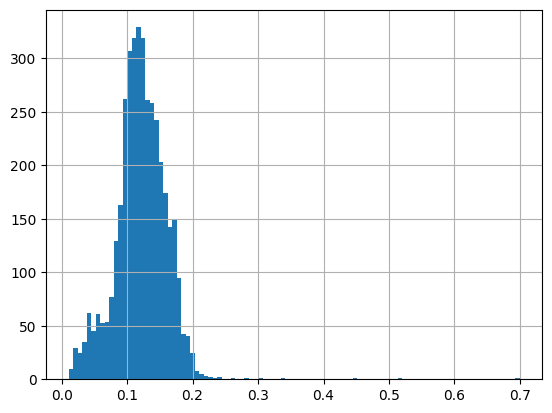

In [51]:
hist = bbox.w_geo.hist(bins=100)

In [52]:
bbox[['h_geo', 'score']]

,h_geo,score
0,0.087930,0.891271
1,0.114926,0.890262
2,0.103017,0.658636
3,0.098877,0.913936
4,0.081354,0.887634
...,...,...
3934,0.077470,0.846000
3935,0.135823,0.934777
3936,0.142151,0.936678
3937,0.037879,0.795385


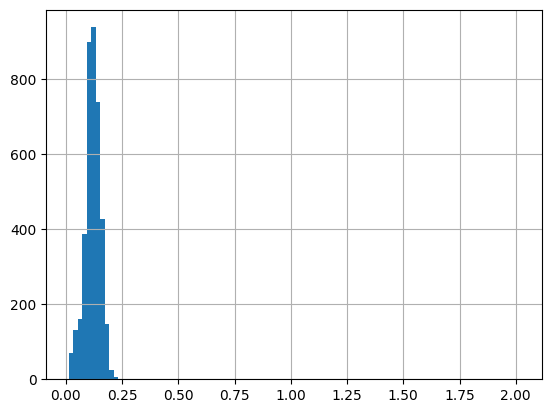

In [53]:
hist = bbox.h_geo.hist(bins=100)

In [ ]:
bbox_filter = bbox[ bbox.]

In [17]:
bbox[['x0_dom', 'y0_dom', 'x1_dom', 'y1_dom', 'score']].to_numpy()

array([[1.9564551e+04, 3.2617572e+04, 1.9625793e+04, 3.2675938e+04,
        8.9127105e-01],
       [1.9045578e+04, 3.2295180e+04, 1.9087074e+04, 3.2371465e+04,
        8.9026242e-01],
       [1.9940979e+04, 3.2655117e+04, 2.0030324e+04, 3.2723498e+04,
        6.5863580e-01],
       ...,
       [1.7891667e+03, 2.6328501e+03, 1.8618301e+03, 2.7272070e+03,
        9.3667817e-01],
       [1.5594504e+03, 4.0171157e+03, 1.6147305e+03, 4.0422588e+03,
        7.9538512e-01],
       [1.3487107e+03, 3.1160054e+03, 1.4184818e+03, 3.1893213e+03,
        9.2347687e-01]], shape=(3939, 5), dtype=float32)

In [54]:
keep_id = nms(bbox[['x0_dom', 'y0_dom', 'x1_dom', 'y1_dom', 'score']].to_numpy(), 0.0)
bbox['keep'] = False
bbox.loc[keep_id, 'keep'] = True

In [55]:
keep_bbox = bbox[bbox.keep]
rm_bbox = bbox[-bbox.keep]

In [56]:
keep_bbox

,offset_x,offset_y,x0,y0,x1,y1,score,xc,yc,w,...,y1_dom,xc_geo,yc_geo,x0_geo,y0_geo,x1_geo,y1_geo,w_geo,h_geo,keep
0,18850.858200,32244.921142,713.692444,372.649506,774.935669,431.015564,0.891271,744.314056,401.832535,61.243225,...,32675.936706,368166.107487,3.956030e+06,368166.061355,3.956030e+06,368166.153619,3.956030e+06,0.092265,0.087930,True
2,18850.858200,32244.921142,1090.120361,410.194824,1179.467407,478.575378,0.658636,1134.793884,444.385101,89.347046,...,32723.496521,368166.695755,3.956030e+06,368166.628454,3.956030e+06,368166.763057,3.956030e+06,0.134604,0.103017,True
4,18850.858200,32244.921142,234.283615,333.732788,320.790497,387.733948,0.887634,277.537056,360.733368,86.506882,...,32632.655090,368165.404275,3.956030e+06,368165.339113,3.956030e+06,368165.469438,3.956030e+06,0.130325,0.081354,True
5,18577.548283,30959.099075,467.777740,1334.659180,508.488007,1410.219849,0.917493,488.132874,1372.439514,40.710266,...,32369.318924,368165.309795,3.956031e+06,368165.279129,3.956031e+06,368165.340460,3.956031e+06,0.061331,0.113834,True
6,18577.548283,30959.099075,751.794006,484.349274,802.971863,560.013123,0.919300,777.382935,522.181198,51.177856,...,31519.112198,368165.745558,3.956032e+06,368165.707007,3.956032e+06,368165.784108,3.956032e+06,0.077101,0.113990,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3932,779.780565,2488.150186,498.868164,312.218811,562.159668,407.174652,0.934920,530.513916,359.696732,63.291504,...,2895.324839,368138.560833,3.956075e+06,368138.513158,3.956075e+06,368138.608508,3.956075e+06,0.095350,0.143053,True
3933,779.780565,2488.150186,1051.708008,482.591034,1152.142822,560.730774,0.933409,1101.925415,521.660904,100.434814,...,3048.880960,368139.421680,3.956075e+06,368139.346026,3.956075e+06,368139.497334,3.956075e+06,0.151308,0.117720,True
3935,779.780565,2488.150186,1170.344971,1067.637329,1245.780640,1157.793701,0.934777,1208.062805,1112.715515,75.435669,...,3645.943888,368139.581579,3.956074e+06,368139.524756,3.956074e+06,368139.638402,3.956074e+06,0.113646,0.135823,True
3936,779.780565,2488.150186,1009.386230,144.699860,1082.049438,239.056778,0.936678,1045.717834,191.878319,72.663208,...,2727.206964,368139.337002,3.956075e+06,368139.282267,3.956076e+06,368139.391736,3.956075e+06,0.109469,0.142151,True


In [57]:
rm_bbox

,offset_x,offset_y,x0,y0,x1,y1,score,xc,yc,w,...,y1_dom,xc_geo,yc_geo,x0_geo,y0_geo,x1_geo,y1_geo,w_geo,h_geo,keep
1,18850.858200,32244.921142,194.720398,50.258369,236.216782,126.543701,0.890262,215.468590,88.401035,41.496384,...,32371.464843,368165.310767,3.956031e+06,368165.279510,3.956031e+06,368165.342025,3.956031e+06,0.062515,0.114926,False
3,18850.858200,32244.921142,651.415466,96.383118,741.366821,162.015244,0.913936,696.391144,129.199181,89.951355,...,32406.936386,368166.035290,3.956031e+06,368165.967533,3.956031e+06,368166.103047,3.956031e+06,0.135514,0.098877,False
7,18577.548283,30959.099075,-0.658761,1412.859009,10.063183,1465.920044,0.704934,4.702211,1439.389526,10.721944,...,32425.019119,368164.581494,3.956031e+06,368164.573417,3.956031e+06,368164.589570,3.956031e+06,0.016153,0.079938,False
22,18304.238365,29673.277008,641.741638,-3.406826,700.661682,87.220642,0.929354,671.201660,41.906908,58.920044,...,29760.497650,368165.173844,3.956035e+06,368165.129462,3.956035e+06,368165.218226,3.956035e+06,0.088765,0.136533,False
23,18304.238365,29673.277008,0.665438,1487.159058,58.913589,1553.642212,0.907648,29.789514,1520.400635,58.248151,...,31226.919220,368164.207540,3.956033e+06,368164.163663,3.956033e+06,368164.251416,3.956032e+06,0.087752,0.100159,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3924,1053.090483,3773.972253,1451.340210,340.718781,1521.463989,400.034576,0.898164,1486.402100,370.376678,70.123779,...,4174.006830,368140.412653,3.956073e+06,368140.359831,3.956073e+06,368140.465475,3.956073e+06,0.105643,0.089361,False
3927,779.780565,2488.150186,1429.077637,131.004059,1523.297974,210.619202,0.936575,1476.187805,170.811630,94.220337,...,2698.769388,368139.985516,3.956075e+06,368139.914543,3.956076e+06,368140.056489,3.956075e+06,0.141945,0.119942,False
3929,779.780565,2488.150186,1257.500732,1345.436890,1329.880371,1441.240845,0.932249,1293.690552,1393.338867,72.379639,...,3929.391031,368139.710579,3.956074e+06,368139.656058,3.956074e+06,368139.765100,3.956074e+06,0.109042,0.144331,False
3934,779.780565,2488.150186,1498.765625,445.121338,1525.047729,496.544495,0.846000,1511.906677,470.832916,26.282104,...,2984.694681,368140.039328,3.956075e+06,368140.019530,3.956075e+06,368140.059125,3.956075e+06,0.039595,0.077470,False


Filter by score

In [62]:
keep_id = nms(bbox[['x0_dom', 'y0_dom', 'x1_dom', 'y1_dom', 'score']].to_numpy(), 0.0)
bbox['keep'] = False
bbox.loc[keep_id, 'keep'] = True

bbox['keep'] = bbox['keep'] * (bbox['score'] > 0.85)

In [63]:
keep_bbox = bbox[bbox.keep]
rm_bbox = bbox[-bbox.keep]

In [64]:
keep_bbox

,offset_x,offset_y,x0,y0,x1,y1,score,xc,yc,w,...,y1_dom,xc_geo,yc_geo,x0_geo,y0_geo,x1_geo,y1_geo,w_geo,h_geo,keep
0,18850.858200,32244.921142,713.692444,372.649506,774.935669,431.015564,0.891271,744.314056,401.832535,61.243225,...,32675.936706,368166.107487,3.956030e+06,368166.061355,3.956030e+06,368166.153619,3.956030e+06,0.092265,0.087930,True
4,18850.858200,32244.921142,234.283615,333.732788,320.790497,387.733948,0.887634,277.537056,360.733368,86.506882,...,32632.655090,368165.404275,3.956030e+06,368165.339113,3.956030e+06,368165.469438,3.956030e+06,0.130325,0.081354,True
5,18577.548283,30959.099075,467.777740,1334.659180,508.488007,1410.219849,0.917493,488.132874,1372.439514,40.710266,...,32369.318924,368165.309795,3.956031e+06,368165.279129,3.956031e+06,368165.340460,3.956031e+06,0.061331,0.113834,True
6,18577.548283,30959.099075,751.794006,484.349274,802.971863,560.013123,0.919300,777.382935,522.181198,51.177856,...,31519.112198,368165.745558,3.956032e+06,368165.707007,3.956032e+06,368165.784108,3.956032e+06,0.077101,0.113990,True
8,18577.548283,30959.099075,924.339966,1381.406128,1014.559753,1446.822388,0.936119,969.449860,1414.114258,90.219788,...,32405.921463,368166.034912,3.956031e+06,368165.966952,3.956031e+06,368166.102871,3.956031e+06,0.135919,0.098551,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3932,779.780565,2488.150186,498.868164,312.218811,562.159668,407.174652,0.934920,530.513916,359.696732,63.291504,...,2895.324839,368138.560833,3.956075e+06,368138.513158,3.956075e+06,368138.608508,3.956075e+06,0.095350,0.143053,True
3933,779.780565,2488.150186,1051.708008,482.591034,1152.142822,560.730774,0.933409,1101.925415,521.660904,100.434814,...,3048.880960,368139.421680,3.956075e+06,368139.346026,3.956075e+06,368139.497334,3.956075e+06,0.151308,0.117720,True
3935,779.780565,2488.150186,1170.344971,1067.637329,1245.780640,1157.793701,0.934777,1208.062805,1112.715515,75.435669,...,3645.943888,368139.581579,3.956074e+06,368139.524756,3.956074e+06,368139.638402,3.956074e+06,0.113646,0.135823,True
3936,779.780565,2488.150186,1009.386230,144.699860,1082.049438,239.056778,0.936678,1045.717834,191.878319,72.663208,...,2727.206964,368139.337002,3.956075e+06,368139.282267,3.956076e+06,368139.391736,3.956075e+06,0.109469,0.142151,True


In [65]:
rm_bbox

,offset_x,offset_y,x0,y0,x1,y1,score,xc,yc,w,...,y1_dom,xc_geo,yc_geo,x0_geo,y0_geo,x1_geo,y1_geo,w_geo,h_geo,keep
1,18850.858200,32244.921142,194.720398,50.258369,236.216782,126.543701,0.890262,215.468590,88.401035,41.496384,...,32371.464843,368165.310767,3.956031e+06,368165.279510,3.956031e+06,368165.342025,3.956031e+06,0.062515,0.114926,False
2,18850.858200,32244.921142,1090.120361,410.194824,1179.467407,478.575378,0.658636,1134.793884,444.385101,89.347046,...,32723.496521,368166.695755,3.956030e+06,368166.628454,3.956030e+06,368166.763057,3.956030e+06,0.134604,0.103017,False
3,18850.858200,32244.921142,651.415466,96.383118,741.366821,162.015244,0.913936,696.391144,129.199181,89.951355,...,32406.936386,368166.035290,3.956031e+06,368165.967533,3.956031e+06,368166.103047,3.956031e+06,0.135514,0.098877,False
7,18577.548283,30959.099075,-0.658761,1412.859009,10.063183,1465.920044,0.704934,4.702211,1439.389526,10.721944,...,32425.019119,368164.581494,3.956031e+06,368164.573417,3.956031e+06,368164.589570,3.956031e+06,0.016153,0.079938,False
9,18577.548283,30959.099075,1458.840820,1172.243652,1525.853638,1235.603516,0.709369,1492.347229,1203.923584,67.012817,...,32194.702591,368166.822670,3.956031e+06,368166.772192,3.956031e+06,368166.873149,3.956031e+06,0.100957,0.095453,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3924,1053.090483,3773.972253,1451.340210,340.718781,1521.463989,400.034576,0.898164,1486.402100,370.376678,70.123779,...,4174.006830,368140.412653,3.956073e+06,368140.359831,3.956073e+06,368140.465475,3.956073e+06,0.105643,0.089361,False
3927,779.780565,2488.150186,1429.077637,131.004059,1523.297974,210.619202,0.936575,1476.187805,170.811630,94.220337,...,2698.769388,368139.985516,3.956075e+06,368139.914543,3.956076e+06,368140.056489,3.956075e+06,0.141945,0.119942,False
3929,779.780565,2488.150186,1257.500732,1345.436890,1329.880371,1441.240845,0.932249,1293.690552,1393.338867,72.379639,...,3929.391031,368139.710579,3.956074e+06,368139.656058,3.956074e+06,368139.765100,3.956074e+06,0.109042,0.144331,False
3934,779.780565,2488.150186,1498.765625,445.121338,1525.047729,496.544495,0.846000,1511.906677,470.832916,26.282104,...,2984.694681,368140.039328,3.956075e+06,368140.019530,3.956075e+06,368140.059125,3.956075e+06,0.039595,0.077470,False


## Save to shp

In [84]:
def save_shp(df, shp_path, type='bbox', crs=None):
    with shapefile.Writer(shp_path) as shp:
        shp.field('name', 'C')
        for idx, row in df.iterrows():
            if type=='bbox':
                # only suits for pandas with ['x0_geo', 'x1_geo', 'y0_geo', 'y1_geo'] keys
                x0 = row.x0_geo
                y0 = row.y0_geo
                x1 = row.x1_geo
                y1 = row.y1_geo

                coord = [[x0, y0],[x1, y0],[x1, y1],[x0, y1],[x0, y0]]
                shp.poly([coord])
                shp.record(str(idx))
            elif type=='points':
                # only suits for pandas with ['x_geo', 'y_geo', 'fid'] keys
                shp.point(row.x_geo, row.y_geo)
                shp.record(str(int(row.fid)))

    if crs:
        if pyproj is None:
            raise ImportError("需要安装 'pyproj' 库来写入 CRS 信息。请运行: pip install pyproj")
        
        try:
            # 从 EPSG 代码生成 WKT 字符串
            # crs_obj = pyproj.CRS.from_string(crs)
            wkt_string = crs.to_wkt()
            
            # 构建 .prj 文件路径
            prj_path = str(shp_path) + '.prj'
            
            # 写入 WKT 字符串到 .prj 文件
            with open(prj_path, 'w') as prj_file:
                prj_file.write(wkt_string)
            print(f"CRS 信息已成功写入到: {prj_path}")
        except Exception as e:
            print(f"错误：无法创建 .prj 文件。CRS字符串 '{crs}' 可能无效。错误信息: {e}")

In [27]:
SHP_DIR = NAS_ROOT / "11_root_position" / "shapefiles"

In [66]:
kp_shp_path = SHP_DIR / "0_keep_bbox"
rm_shp_path = SHP_DIR / "0_remove_bbox"
save_shp(keep_bbox, kp_shp_path)
save_shp(rm_bbox, rm_shp_path)

In [ ]:
bbox_dom_in = pd.DataFrame().astype(np.uint64)

bbox_dom_in["x_geo"] = keep_bbox["xc_geo"]
bbox_dom_in["y_geo"] = keep_bbox["yc_geo"]
bbox_dom_in["fid"] = bbox_dom_in.index.values

In [75]:
bbox_dom_in

,x_geo,y_geo,fid
0,368166.107487,3.956030e+06,0
4,368165.404275,3.956030e+06,4
5,368165.309795,3.956031e+06,5
6,368165.745558,3.956032e+06,6
8,368166.034912,3.956031e+06,8
...,...,...,...
3932,368138.560833,3.956075e+06,3932
3933,368139.421680,3.956075e+06,3933
3935,368139.581579,3.956074e+06,3935
3936,368139.337002,3.956075e+06,3936


In [85]:
save_shp(bbox_dom_in, SHP_DIR / "0_unordered_center_points", type='points', crs=dom.crs)

CRS 信息已成功写入到: /home/crest/w/hwang_Pro/data/202509_tanashi_broccoli/11_root_position/shapefiles/0_unordered_center_points.prj
